# **THÊM CÁC THƯ VIỆN CẦN THIẾT**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Kiểm tra dùng cuda GPU để tăng tốc độ huấn luyện
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Định nghĩa các siêu tham số
BATCH_SIZE = 64
EPOCHS = 150
LEARNING_RATE = 0.0005 # tốc độ học
WEIGHT_DECAY = 5e-4 #Phạt trọng số

SCHEDULER_PATIENCE = 5 #5 lần không cải thiện val loss thì giảm tốc độ học
SCHEDULER_FACTOR = 0.5 #mỗi lần giảm 50%
EARLY_STOP_PATIENCE = 15 #15 lần không cải thiện thì dừng huấn luyện

Using device: cuda


# **TIỀN XỬ LÝ DỮ LIỆU TRƯỚC KHI HUẤN LUYỆN**

In [3]:
#Tiền xử lý cho tập huấn luyện
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #Cắt ngẫu nhiên một vùng ảnh kích thước 32×32, padding thêm 4 pixel ở mỗi cạnh
    transforms.RandomHorizontalFlip(),  #Ngẫu nhiên lật ảnh theo chiều ngang
    transforms.ToTensor(), #Chuyển thành định dạng Tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)), # Chuẩn hóa mean và std
])

#Tiền xử lý cho tập kiểm tra
transform_test = transforms.Compose([
    transforms.ToTensor(), # Chuyển dữ liệu thành định dạng Tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)), #Chuẩn hóa dữ liệu
])

#Load train dataset từ thư viện torchvision
full_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)

#Load test dataset từ thư viện
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

#Chia tập train dataset thành train và validation
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

#Chuyển thành dataloader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#Định nghĩa các class trong CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f'Number of training images: {len(trainset)}')
print(f'Number of validation images: {len(valset)}')
print(f'Number of test images: {len(testset)}')
print(full_trainset.classes)

100%|██████████| 170M/170M [00:01<00:00, 89.4MB/s]


Number of training images: 40000
Number of validation images: 10000
Number of test images: 10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# **KIẾN TRÚC MÔ HÌNH**

In [4]:
#Xây dựng khối cơ bản cho mô hình
class BasicBlock(nn.Module):
    expansion = 1 #Giữ nguyên đầu ra

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        #Xây dựng thành phần skip connection (đặc trưng của ResNet)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

#Kiến trúc tổng thể của mô hình
class ResNet34(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet34, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        #Các tầng Residual
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        self._initialize_weights()

    #Tạo chuỗi basic block
    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * BasicBlock.expansion

        return nn.Sequential(*layers)

    #Khởi tạo trọng số dùng He (Kaiming) initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# **KHỞI TẠO MÔ HÌNH VÀ CÁ HÀM CHO QUÁ TRÌNH HUẤN LUYỆN**

In [5]:
#Khởi tạo mô hình là kiến trúc vừa tạo
model = ResNet34(num_classes=10).to(device)

#Hàm Loss
criterion = nn.CrossEntropyLoss()

#Hàm tối ưu
optimizer = optim.Adam(
    model.parameters(), #tối ưu tham số
    lr=LEARNING_RATE, #tốc độ học
    weight_decay=WEIGHT_DECAY #L2 regularzation, tinh chỉnh giảm overfitting
)

#Bộ điều chỉnh tốc độ học
scheduler = ReduceLROnPlateau(
    optimizer, mode='min', #Theo dõi giá trị loss
    factor=SCHEDULER_FACTOR,  #Tỉ số giảm
    patience=SCHEDULER_PATIENCE #Ngưỡng cải thiện loss, không giảm thì điều chỉnh LR
    )

# **XÂY DỰNG HÀM HUẤN LUYỆN VÀ HÀM KIỂM ĐỊNH**

In [6]:
#Hàm huấn luyện
def train_epoch(model, dataloader, criterion, optimizer, device):
    #Khởi tạo chế độ huấn luyện
    model.train()
    #Các biến lưu giá trị tạm thời
    running_loss = 0.0
    correct = 0
    total = 0

    #Dùng thư viện tqdm để theo dõi quá trình train
    pbar = tqdm(dataloader, desc='Training')
    for inputs, labels in pbar:
        #Mapping đầu vào vào device(cuda)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() #Reset gradient
        outputs = model(inputs) #Forward pass
        loss = criterion(outputs, labels) #Tính loss
        loss.backward() #Back prop
        optimizer.step()  #Tối ưu theo

        running_loss += loss.item() #Tính tổng loss các batch trong 1 epoch
        _, predicted = outputs.max(1) #Dự đoán đầu ra
        #Tính tổng số mẫu và số dự đoán đúng
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{running_loss/(pbar.n+1):.3f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    return running_loss / len(dataloader), 100. * correct / total

#Hàm validation
def validate(model, dataloader, criterion, device):
    #Khởi tạo chế độ kiểm định
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    #Tắt gradient
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) #Forward pass
            loss = criterion(outputs, labels) #Tính loss

            running_loss += loss.item() #Tính tổng loss
            _, predicted = outputs.max(1) #Dự đoán đầu ra
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total

# **HUẤN LUYỆN MÔ HÌNH**


Epoch 1/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.65it/s]

Train Loss: 1.506 | Train Acc: 44.87%
Val Loss: 1.340 | Val Acc: 51.28%


Saved best model with accuracy: 51.28%

Epoch 2/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.55it/s]

Train Loss: 1.051 | Train Acc: 62.87%
Val Loss: 1.024 | Val Acc: 63.64%


Saved best model with accuracy: 63.64%

Epoch 3/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.26it/s]

Train Loss: 0.853 | Train Acc: 70.39%
Val Loss: 0.847 | Val Acc: 69.93%


Saved best model with accuracy: 69.93%

Epoch 4/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.08it/s]

Train Loss: 0.734 | Train Acc: 74.62%
Val Loss: 0.813 | Val Acc: 72.77%


Saved best model with accuracy: 72.77%

Epoch 5/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.22it/s]

Train Loss: 0.667 | Train Acc: 76.97%
Val Loss: 0.779 | Val Acc: 73.77%


Saved best model with accuracy: 73.77%

Epoch 6/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.22it/s]

Train Loss: 0.613 | Train Acc: 79.03%
Val Loss: 0.822 | Val Acc: 72.71%


Early Stopping Counter: 1/15

Epoch 7/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 32.88it/s]

Train Loss: 0.568 | Train Acc: 80.63%
Val Loss: 0.617 | Val Acc: 78.73%


Saved best model with accuracy: 78.73%

Epoch 8/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.26it/s]

Train Loss: 0.531 | Train Acc: 81.87%
Val Loss: 0.696 | Val Acc: 76.86%


Early Stopping Counter: 1/15

Epoch 9/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.04it/s]

Train Loss: 0.496 | Train Acc: 83.19%
Val Loss: 0.591 | Val Acc: 80.02%


Saved best model with accuracy: 80.02%

Epoch 10/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.27it/s]

Train Loss: 0.470 | Train Acc: 84.07%
Val Loss: 0.530 | Val Acc: 81.78%


Saved best model with accuracy: 81.78%

Epoch 11/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.44it/s]

Train Loss: 0.449 | Train Acc: 84.95%
Val Loss: 0.546 | Val Acc: 81.60%


Early Stopping Counter: 1/15

Epoch 12/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.38it/s]

Train Loss: 0.419 | Train Acc: 85.73%
Val Loss: 0.518 | Val Acc: 82.21%


Saved best model with accuracy: 82.21%

Epoch 13/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.40it/s]

Train Loss: 0.402 | Train Acc: 86.28%
Val Loss: 0.569 | Val Acc: 80.90%


Early Stopping Counter: 1/15

Epoch 14/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.42it/s]

Train Loss: 0.386 | Train Acc: 86.80%
Val Loss: 0.530 | Val Acc: 82.04%


Early Stopping Counter: 2/15

Epoch 15/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.41it/s]

Train Loss: 0.373 | Train Acc: 87.39%
Val Loss: 0.416 | Val Acc: 85.93%


Saved best model with accuracy: 85.93%

Epoch 16/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.61it/s]

Train Loss: 0.352 | Train Acc: 88.04%
Val Loss: 0.553 | Val Acc: 81.26%


Early Stopping Counter: 1/15

Epoch 17/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.61it/s]

Train Loss: 0.342 | Train Acc: 88.39%
Val Loss: 0.444 | Val Acc: 84.81%


Early Stopping Counter: 2/15

Epoch 18/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.53it/s]

Train Loss: 0.339 | Train Acc: 88.53%
Val Loss: 0.424 | Val Acc: 85.56%


Early Stopping Counter: 3/15

Epoch 19/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.82it/s]

Train Loss: 0.322 | Train Acc: 88.91%
Val Loss: 0.455 | Val Acc: 84.85%


Early Stopping Counter: 4/15

Epoch 20/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.66it/s]

Train Loss: 0.310 | Train Acc: 89.40%
Val Loss: 0.426 | Val Acc: 85.58%


Early Stopping Counter: 5/15

Epoch 21/150
Learning Rate: 0.000500


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.68it/s]

Train Loss: 0.301 | Train Acc: 89.72%
Val Loss: 0.430 | Val Acc: 85.57%


Early Stopping Counter: 6/15

Epoch 22/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.77it/s]

Train Loss: 0.219 | Train Acc: 92.52%
Val Loss: 0.306 | Val Acc: 89.80%


Saved best model with accuracy: 89.80%

Epoch 23/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.73it/s]

Train Loss: 0.201 | Train Acc: 93.14%
Val Loss: 0.314 | Val Acc: 89.68%


Early Stopping Counter: 1/15

Epoch 24/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.65it/s]

Train Loss: 0.186 | Train Acc: 93.64%
Val Loss: 0.288 | Val Acc: 89.79%



Epoch 25/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.74it/s]

Train Loss: 0.184 | Train Acc: 93.85%
Val Loss: 0.331 | Val Acc: 89.24%


Early Stopping Counter: 1/15

Epoch 26/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.75it/s]

Train Loss: 0.176 | Train Acc: 93.99%
Val Loss: 0.307 | Val Acc: 90.20%


Saved best model with accuracy: 90.20%
Early Stopping Counter: 2/15

Epoch 27/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.80it/s]

Train Loss: 0.167 | Train Acc: 94.31%
Val Loss: 0.308 | Val Acc: 89.88%


Early Stopping Counter: 3/15

Epoch 28/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.70it/s]

Train Loss: 0.163 | Train Acc: 94.38%
Val Loss: 0.311 | Val Acc: 89.87%


Early Stopping Counter: 4/15

Epoch 29/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.80it/s]

Train Loss: 0.160 | Train Acc: 94.65%
Val Loss: 0.315 | Val Acc: 89.79%


Early Stopping Counter: 5/15

Epoch 30/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.75it/s]

Train Loss: 0.156 | Train Acc: 94.59%
Val Loss: 0.282 | Val Acc: 90.56%


Saved best model with accuracy: 90.56%

Epoch 31/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.93it/s]

Train Loss: 0.149 | Train Acc: 94.82%
Val Loss: 0.325 | Val Acc: 89.68%


Early Stopping Counter: 1/15

Epoch 32/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.78it/s]

Train Loss: 0.151 | Train Acc: 94.80%
Val Loss: 0.313 | Val Acc: 89.99%


Early Stopping Counter: 2/15

Epoch 33/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.86it/s]

Train Loss: 0.142 | Train Acc: 95.09%
Val Loss: 0.298 | Val Acc: 90.46%


Early Stopping Counter: 3/15

Epoch 34/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.86it/s]

Train Loss: 0.135 | Train Acc: 95.28%
Val Loss: 0.334 | Val Acc: 89.58%


Early Stopping Counter: 4/15

Epoch 35/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.78it/s]

Train Loss: 0.141 | Train Acc: 95.05%
Val Loss: 0.337 | Val Acc: 89.31%


Early Stopping Counter: 5/15

Epoch 36/150
Learning Rate: 0.000250


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.64it/s]

Train Loss: 0.135 | Train Acc: 95.38%
Val Loss: 0.326 | Val Acc: 89.86%


Early Stopping Counter: 6/15

Epoch 37/150
Learning Rate: 0.000125


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.92it/s]

Train Loss: 0.087 | Train Acc: 97.17%
Val Loss: 0.283 | Val Acc: 91.05%


Saved best model with accuracy: 91.05%
Early Stopping Counter: 7/15

Epoch 38/150
Learning Rate: 0.000125


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.79it/s]

Train Loss: 0.074 | Train Acc: 97.59%
Val Loss: 0.277 | Val Acc: 91.66%


Saved best model with accuracy: 91.66%

Epoch 39/150
Learning Rate: 0.000125


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.83it/s]

Train Loss: 0.072 | Train Acc: 97.60%
Val Loss: 0.293 | Val Acc: 91.22%


Early Stopping Counter: 1/15

Epoch 40/150
Learning Rate: 0.000125


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.88it/s]

Train Loss: 0.068 | Train Acc: 97.67%
Val Loss: 0.298 | Val Acc: 91.16%


Early Stopping Counter: 2/15

Epoch 41/150
Learning Rate: 0.000125


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.87it/s]

Train Loss: 0.066 | Train Acc: 97.77%
Val Loss: 0.293 | Val Acc: 91.23%


Early Stopping Counter: 3/15

Epoch 42/150
Learning Rate: 0.000125


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.89it/s]

Train Loss: 0.062 | Train Acc: 97.95%
Val Loss: 0.292 | Val Acc: 91.19%


Early Stopping Counter: 4/15

Epoch 43/150
Learning Rate: 0.000125


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.86it/s]

Train Loss: 0.064 | Train Acc: 97.86%
Val Loss: 0.298 | Val Acc: 91.25%


Early Stopping Counter: 5/15

Epoch 44/150
Learning Rate: 0.000125


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.78it/s]

Train Loss: 0.060 | Train Acc: 98.07%
Val Loss: 0.305 | Val Acc: 91.42%


Early Stopping Counter: 6/15

Epoch 45/150
Learning Rate: 0.000063


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.94it/s]

Train Loss: 0.041 | Train Acc: 98.72%
Val Loss: 0.263 | Val Acc: 92.24%


Saved best model with accuracy: 92.24%

Epoch 46/150
Learning Rate: 0.000063


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.92it/s]

Train Loss: 0.034 | Train Acc: 98.92%
Val Loss: 0.288 | Val Acc: 91.84%


Early Stopping Counter: 1/15

Epoch 47/150
Learning Rate: 0.000063


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.89it/s]

Train Loss: 0.033 | Train Acc: 98.94%
Val Loss: 0.277 | Val Acc: 92.22%


Early Stopping Counter: 2/15

Epoch 48/150
Learning Rate: 0.000063


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.92it/s]

Train Loss: 0.029 | Train Acc: 99.12%
Val Loss: 0.289 | Val Acc: 92.16%


Early Stopping Counter: 3/15

Epoch 49/150
Learning Rate: 0.000063


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.96it/s]

Train Loss: 0.031 | Train Acc: 99.05%
Val Loss: 0.291 | Val Acc: 91.66%


Early Stopping Counter: 4/15

Epoch 50/150
Learning Rate: 0.000063


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.86it/s]

Train Loss: 0.029 | Train Acc: 99.14%
Val Loss: 0.287 | Val Acc: 92.20%


Early Stopping Counter: 5/15

Epoch 51/150
Learning Rate: 0.000063


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.79it/s]

Train Loss: 0.030 | Train Acc: 99.06%
Val Loss: 0.310 | Val Acc: 91.59%


Early Stopping Counter: 6/15

Epoch 52/150
Learning Rate: 0.000031


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.90it/s]

Train Loss: 0.022 | Train Acc: 99.37%
Val Loss: 0.292 | Val Acc: 92.29%


Saved best model with accuracy: 92.29%
Early Stopping Counter: 7/15

Epoch 53/150
Learning Rate: 0.000031


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.83it/s]

Train Loss: 0.018 | Train Acc: 99.47%
Val Loss: 0.289 | Val Acc: 92.49%


Saved best model with accuracy: 92.49%
Early Stopping Counter: 8/15

Epoch 54/150
Learning Rate: 0.000031


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.87it/s]

Train Loss: 0.016 | Train Acc: 99.58%
Val Loss: 0.293 | Val Acc: 92.39%


Early Stopping Counter: 9/15

Epoch 55/150
Learning Rate: 0.000031


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.75it/s]

Train Loss: 0.017 | Train Acc: 99.57%
Val Loss: 0.282 | Val Acc: 92.53%


Saved best model with accuracy: 92.53%
Early Stopping Counter: 10/15

Epoch 56/150
Learning Rate: 0.000031


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.95it/s]

Train Loss: 0.015 | Train Acc: 99.57%
Val Loss: 0.283 | Val Acc: 92.55%


Saved best model with accuracy: 92.55%
Early Stopping Counter: 11/15

Epoch 57/150
Learning Rate: 0.000031


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.92it/s]

Train Loss: 0.015 | Train Acc: 99.60%
Val Loss: 0.297 | Val Acc: 92.34%


Early Stopping Counter: 12/15

Epoch 58/150
Learning Rate: 0.000016


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.85it/s]

Train Loss: 0.013 | Train Acc: 99.67%
Val Loss: 0.293 | Val Acc: 92.60%


Saved best model with accuracy: 92.60%
Early Stopping Counter: 13/15

Epoch 59/150
Learning Rate: 0.000016


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.97it/s]

Train Loss: 0.013 | Train Acc: 99.64%
Val Loss: 0.288 | Val Acc: 92.57%


Early Stopping Counter: 14/15

Epoch 60/150
Learning Rate: 0.000016


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.85it/s]

Train Loss: 0.012 | Train Acc: 99.72%
Val Loss: 0.287 | Val Acc: 92.73%


Saved best model with accuracy: 92.73%
Early Stopping Counter: 15/15
Early stopping triggered!


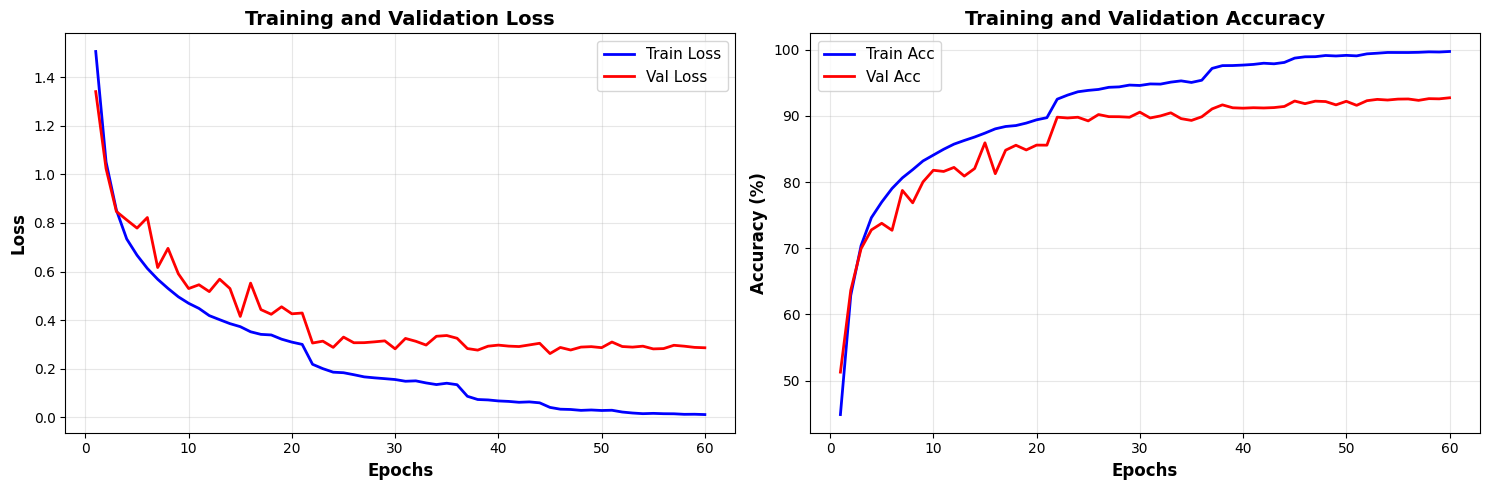

In [7]:
# Khởi tạo các biến lưu giá trị acc và đếm dừng huấn luyện
best_acc = 0.0                    # Độ chính xác cao nhất đạt được trên tập validation
best_val_loss = float('inf')      # Giá trị loss nhỏ nhất trên tập validation
early_stop_counter = 0            # Bộ đếm số lần không cải thiện để dừng sớm


# Các list lưu lịch sử huấn luyện
train_losses, train_accs = [], []   # Lưu loss và accuracy của tập huấn luyện
val_losses, val_accs = [], []       # Lưu loss và accuracy của tập validation

#Hàm lấy dự đoán từ mô hình
def get_all_preds(model, dataloader, device):
    model.eval()                      # Chuyển sang chế độ đánh giá (tắt dropout, batchnorm)
    all_preds = []                    # Lưu toàn bộ dự đoán
    all_labels = []                   # Lưu toàn bộ nhãn thật

    with torch.no_grad():             # Không tính gradient để tiết kiệm bộ nhớ
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Lấy class có xác suất cao nhất
            all_preds.extend(preds.cpu().numpy())   # Chuyển về CPU để lưu
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

#Hàm lặp huấn luyện
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, valloader, criterion, device)

    scheduler.step(val_loss) #Chỉnh tốc độ học theo val_loss

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}%')

    #Vẽ confsion matrix cho tập train
    y_true_train, y_pred_train = get_all_preds(model, trainloader, device)
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_train, annot=False, fmt='d', cmap='Blues')
    plt.title(f'Train Confusion Matrix - Epoch {epoch+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_train_epoch_{epoch+1}.png', dpi=300, bbox_inches='tight')
    plt.close()

    #Vẽ confusion matrix cho tập val
    y_true_val, y_pred_val = get_all_preds(model, valloader, device)
    cm_val = confusion_matrix(y_true_val, y_pred_val)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_val, annot=False, fmt='d', cmap='Oranges')
    plt.title(f'Validation Confusion Matrix - Epoch {epoch+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_val_epoch_{epoch+1}.png', dpi=300, bbox_inches='tight')
    plt.close()

    #Hàm save mô hình, early stop nếu không cải thiện loss sau 15 lần
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
        }, 'resnet34_cifar10.pth')
        print(f'Saved best model with accuracy: {best_acc:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"Early Stopping Counter: {early_stop_counter}/{EARLY_STOP_PATIENCE}")
        if early_stop_counter >= EARLY_STOP_PATIENCE:
            print("Early stopping triggered!")
            break

final_epochs = len(train_losses)
epochs_range = range(1, final_epochs + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

#Vẽ đồ thị trực quan quá trình huấn luyện
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, train_accs, 'b-', label='Train Acc', linewidth=2)
ax2.plot(epochs_range, val_accs, 'r-', label='Val Acc', linewidth=2)
ax2.set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# **KIỂM TRA MÔ HÌNH**

In [8]:
#Tải mô hình
checkpoint = torch.load('resnet34_cifar10.pth')
model.load_state_dict(checkpoint['model_state_dict'])

#Hàm kiểm tra
def test_model(model, dataloader, criterion, device, class_names):
    model.eval()  # Đặt model vào chế độ đánh giá (evaluation mode)

    all_preds = []   # Danh sách lưu tất cả dự đoán của mô hình
    all_labels = []  # Danh sách lưu nhãn thật tương ứng
    running_loss = 0.0  # Biến cộng dồn loss qua các batch
    correct = 0         # Đếm số lượng dự đoán đúng
    total = 0           # Đếm tổng số mẫu đã kiểm thử

    # Không tính gradient trong quá trình test
    with torch.no_grad():
        # Dùng tqdm để theo dõi quá trình
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            # Chuyển dữ liệu sang GPU hoặc CPU tùy theo thiết bị
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) #Forward pass
            loss = criterion(outputs, labels) #Tính loss
            running_loss += loss.item() #Tính tổng loss
            _, predicted = outputs.max(1) #Đầu ra dự đoán

            # Lưu dự đoán và nhãn thật để phân tích sau (ví dụ confusion matrix)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Cập nhật tổng số mẫu và số mẫu dự đoán đúng
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Tính trung bình loss và accuracy trên toàn bộ tập test
    test_loss = running_loss / len(dataloader)
    test_acc = 100. * correct / total

    # In kết quả đánh giá cuối cùng
    print(f"\nKẾT QUẢ TEST:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}% ({correct}/{total})")

    return np.array(all_labels), np.array(all_preds), test_loss, test_acc

Testing: 100%|██████████| 157/157 [00:04<00:00, 34.16it/s]



KẾT QUẢ TEST:
Test Loss: 0.3077
Test Accuracy: 92.98% (9298/10000)

Accuracy per class:
airplane  : 94.10%
automobile: 97.00%
bird      : 88.40%
cat       : 87.40%
deer      : 94.50%
dog       : 88.60%
frog      : 95.30%
horse     : 94.50%
ship      : 95.20%
truck     : 94.80%


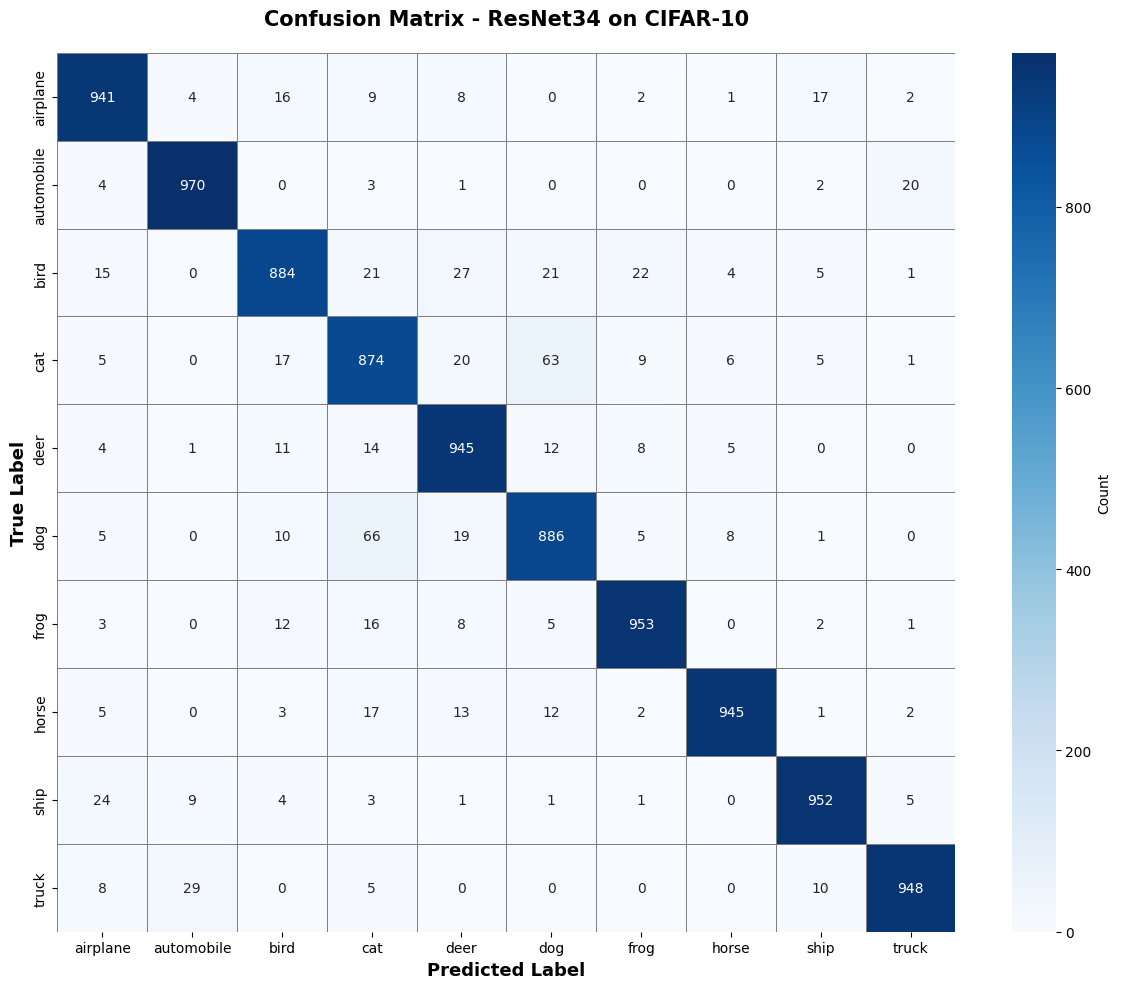

In [9]:
y_true, y_pred, test_loss, test_acc = test_model(model, testloader, criterion, device, classes)

#In độ chính xác từng class và ma trận nhầm lẫn
print("\nAccuracy per class:")
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(classes):
    print(f"{class_name:10s}: {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')

plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.title('Confusion Matrix - ResNet34 on CIFAR-10', fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()